#Import Dependencies

In [ ]:
#Add cuda toolkit
import os
os.environ['CUDA_HOME'] = "/usr/local/cuda"

In [ ]:
#Update numba package
!pip install --upgrade numba

Requirement already up-to-date: numba in /usr/local/lib/python3.6/dist-packages (0.52.0)


In [ ]:
from numba import cuda
import numpy as npy 
import matplotlib.pyplot as plt
import cv2
import matplotlib.image as img 
import numpy as np

#Image Cropping using Sequential Implementation

In [ ]:
def run_sequential(image, startRow, startCol, endRow, endCol):
  # determining dimesion of image width(w) height(h) 
  numRows, numCols = image.shape[:2] 
  
  if (startRow < 0 or startCol < 0 or endRow > numRows or endCol > numCols):
    print("Error: The input dimensions for cropped image are out of range.")
    print("Rows Range: " + str(numRows) + " and Column Range: " + str(numCols) + ". Please try again with correct dimensions.")
    return 
  if (endRow <= startRow or endCol <= startCol):
    print("Error: Ending row and column values must be greater than starting row and column values respectively")
    return

  croppedWidth = endRow - startRow
  croppedHeight = endCol - startCol
  croppedImage = npy.zeros([croppedWidth, croppedHeight, 3]) 

  for i in range(0, croppedWidth): 
      for j in range(0, croppedHeight): 
        # cropping start from startRow, startCol pixel of original image 
          croppedImage[i, j]= image[startRow+i, startCol+j]
  

  plt.figure(figsize=(12, 12))
  plt.subplot(121), plt.imshow(image)
  plt.title("Original Image"), plt.xticks([]), plt.yticks([])

  plt.figure(figsize=(12, 12))
  plt.subplot(121), plt.imshow((croppedImage).astype(np.uint8)),plt.xticks([]), plt.yticks([])
  plt.title("Cropped Image - Sequential")

  croppedImageCV2 = image[startRow:startRow+croppedWidth, startCol:startCol+croppedHeight]
  plt.figure(figsize=(12, 12))
  plt.subplot(121), plt.imshow((croppedImageCV2).astype(npy.uint8)),plt.xticks([]), plt.yticks([])
  plt.title("Cropped Image - CV2")

  comparison = croppedImageCV2 == croppedImage
  equal_arrays = comparison.all()
  print("Manual cropped image matches cv2 cropped image: " + str(equal_arrays))
  # save image  
  img.imsave('cropped.jpg', (croppedImage).astype(npy.uint8))
  img.imsave('croppedcv2.jpg', (croppedImage).astype(npy.uint8))

In [ ]:
## For runtime
def crop_sequential(image, startRow, startCol, croppedWidth, croppedHeight, croppedImage):
  for i in range(0, croppedWidth): 
      for j in range(0, croppedHeight): 
        # cropping start from startRow, startCol pixel of original image 
          croppedImage[i, j]= image[startRow+i, startCol+j]


##1080p Results

1080p Image

Manual cropped image matches cv2 cropped image: True


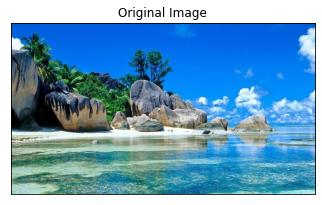

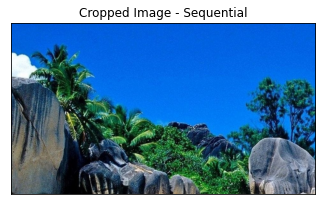

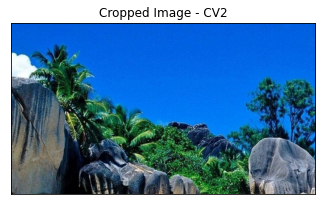

In [ ]:
#Import the image
image = cv2.imread("1080p_image.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print("1080p Image")
print()

numRows, numCols = image.shape[:2] 

startRow = 0
startCol = 0
endRow = numRows//2
endCol = numCols//2

## For image results

run_sequential(image, startRow, startCol, endRow, endCol)

In [ ]:
## For timing

croppedWidth = endRow - startRow
croppedHeight = endCol - startCol
croppedImage = np.zeros([croppedWidth, croppedHeight, 3]) 

%timeit crop_sequential(image,startRow, startCol, croppedWidth, croppedHeight, croppedImage)

1 loop, best of 3: 343 ms per loop


##4k Results

4k Image

Manual cropped image matches cv2 cropped image: True


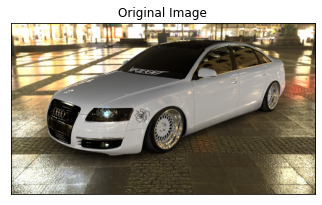

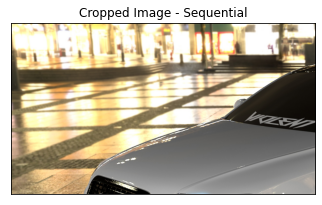

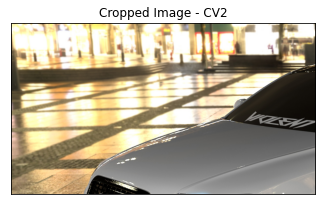

In [ ]:
image_4k = cv2.imread("4k_image.jpg")
image_4k = cv2.cvtColor(image_4k, cv2.COLOR_BGR2RGB)
print("4k Image")
print()

numRows, numCols = image_4k.shape[:2] 
startRow = 0
startCol = 0
endRow = numRows//2
endCol = numCols//2 

## For image results

run_sequential(image_4k, startRow, startCol, endRow, endCol)

In [ ]:
## For timing

croppedWidth = endRow - startRow
croppedHeight = endCol - startCol
croppedImage = np.zeros([croppedWidth, croppedHeight, 3]) 

%timeit crop_sequential(image_4k,startRow, startCol, croppedWidth, croppedHeight, croppedImage)

1 loop, best of 3: 1.36 s per loop


##8k Results

8k Image

Manual cropped image matches cv2 cropped image: True


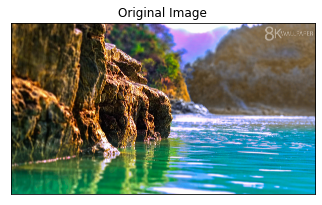

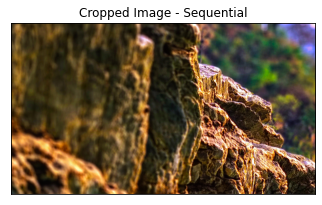

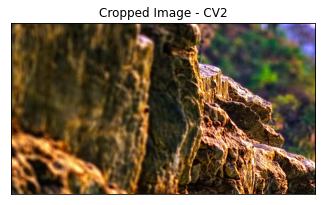

In [ ]:
image_8k = cv2.imread("8K_image.jpg")
image_8k = cv2.cvtColor(image_8k, cv2.COLOR_BGR2RGB)
print("8k Image")
print()

numRows, numCols = image_8k.shape[:2] 
startRow = 0
startCol = 0
endRow = numRows//2 
endCol = numCols//2 

## For image results
run_sequential(image_8k, startRow, startCol, endRow, endCol)

In [ ]:
## For timing

croppedWidth = endRow - startRow
croppedHeight = endCol - startCol
croppedImage = np.zeros([croppedWidth, croppedHeight, 3]) 
%timeit crop_sequential(image_8k,startRow, startCol, croppedWidth, croppedHeight, croppedImage)

1 loop, best of 3: 5.45 s per loop


#CUDA Kernel Function for Parallel Cropping

In [ ]:
#Kernel Function
@cuda.jit
def crop(image, croppedImage, startRow, startCol, croppedWidth, croppedHeight):
  thread_x, thread_y = cuda.grid(2)
  if thread_x < image.shape[0] and thread_x < croppedWidth and thread_y < image.shape[1] and thread_y < croppedHeight:
    croppedImage[thread_x][thread_y][0] = image[startRow+thread_x][startCol+thread_y][0]
    croppedImage[thread_x][thread_y][1] = image[startRow+thread_x][startCol+thread_y][1]
    croppedImage[thread_x][thread_y][2] = image[startRow+thread_x][startCol+thread_y][2]

#Image Cropping using Unified GPU Memory Management

##Code

In [ ]:
def run(image, startRow, startCol, endRow, endCol):
  # determining dimesion of image width(w) height(h) 
  numRows, numCols = image.shape[:2] 
  
  if (startRow < 0 or startCol < 0 or endRow > numRows or endCol > numCols):
    print("Error: The input dimensions for cropped image are out of range.")
    print("Rows Range: " + str(numRows) + " and Column Range: " + str(numCols) + ". Please try again with correct dimensions.")
    return 
  if (endRow <= startRow or endCol <= startCol):
    print("Error: Ending row and column values must be greater than starting row and column values respectively")
    return

  croppedWidth = endRow - startRow
  croppedHeight = endCol - startCol
  croppedImage = np.zeros([croppedWidth, croppedHeight, 3]) 

  #Setup grid size and thread count
  grid_size = image.shape[:2]
  thread_no = (1, 1)

  #Call the kernel
  crop[grid_size, thread_no](image, croppedImage, startRow, startCol, croppedWidth, croppedHeight)

  plt.figure(figsize=(12, 12))
  plt.subplot(121), plt.imshow(image)
  plt.title("Original Image"), plt.xticks([]), plt.yticks([])

  plt.figure(figsize=(12, 12))
  plt.subplot(121), plt.imshow((croppedImage).astype(np.uint8)),plt.xticks([]), plt.yticks([])
  plt.title("Cropped Image - Unified Memory Management")

  croppedImageCV2 = image[startRow:startRow+croppedWidth, startCol:startCol+croppedHeight]
  plt.figure(figsize=(12, 12))
  plt.subplot(121), plt.imshow((croppedImageCV2).astype(np.uint8)),plt.xticks([]), plt.yticks([])
  plt.title("Cropped Image - CV2")

  comparison = croppedImageCV2 == croppedImage
  equal_arrays = comparison.all()
  print("Manual cropped image matches cv2 cropped image: " + str(equal_arrays))
  # save image  
  img.imsave('cropped.jpg', (croppedImage).astype(npy.uint8))
  img.imsave('croppedcv2.jpg', (croppedImage).astype(npy.uint8))

##1080p Results

1080p Image

Manual cropped image matches cv2 cropped image: True


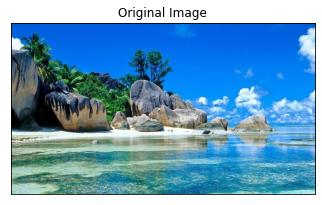

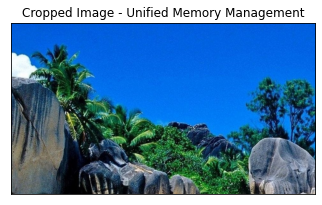

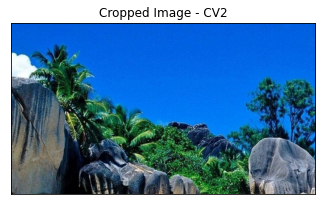

In [ ]:
## Image plotting
#Import the image
image = cv2.imread("1080p_image.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print("1080p Image")
print()

numRows, numCols = image.shape[:2] 
startRow =  0
startCol = 0
endRow = numRows//2
endCol = numCols//2

run(image, startRow, startCol, endRow, endCol)

In [ ]:
## Runtime Comparison
if (startRow < 0 or startCol < 0 or endRow < startRow or endCol < startCol):
    print("The input dimensions for cropped image are invalid. Please try again with correct dimensions.")
else: 
  croppedWidth = endRow - startRow
  croppedHeight = endCol - startCol
  croppedImage = np.zeros([croppedWidth, croppedHeight, 3]) 

  print("Runtime for NUMBA Parallel Cropping")
  for i in [2**x for x in range(6)]:
      grid_size = ((image.shape[0] + i )// i, (image.shape[1] + i) // i)
      thread_no = (i, i)
      print(f"Grid Size: ({grid_size[0]}, {grid_size[1]})\nThreads Per Block: ({i}, {i})")
      %timeit crop[grid_size, thread_no](image, croppedImage, startRow, startCol, croppedWidth, croppedHeight)

  print()
  print("Timing CV2 Cropping.")

  %timeit crop_img = image[startRow:startRow+croppedWidth, startCol:startCol+croppedHeight]

Runtime for NUMBA Parallel Cropping
Grid Size: (1081, 1921)
Threads Per Block: (1, 1)
100 loops, best of 3: 11.4 ms per loop
Grid Size: (541, 961)
Threads Per Block: (2, 2)
100 loops, best of 3: 9.83 ms per loop
Grid Size: (271, 481)
Threads Per Block: (4, 4)
100 loops, best of 3: 9.5 ms per loop
Grid Size: (136, 241)
Threads Per Block: (8, 8)
100 loops, best of 3: 9.46 ms per loop
Grid Size: (68, 121)
Threads Per Block: (16, 16)
100 loops, best of 3: 9.47 ms per loop
Grid Size: (34, 61)
Threads Per Block: (32, 32)
100 loops, best of 3: 10.1 ms per loop

Timing CV2 Cropping.
The slowest run took 8.04 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 416 ns per loop


##4k Results

4k Image

Manual cropped image matches cv2 cropped image: True


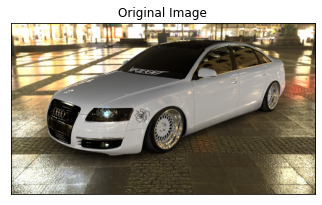

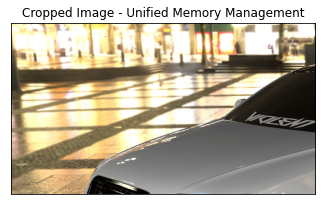

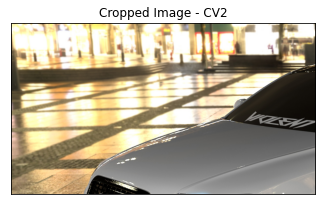

In [ ]:
## Image plotting
image_4k = cv2.imread("4k_image.jpg")
image_4k = cv2.cvtColor(image_4k, cv2.COLOR_BGR2RGB)
print("4k Image")
print()

numRows, numCols = image_4k.shape[:2] 
startRow = 0
startCol = 0
endRow = numRows//2
endCol = numCols//2 
run(image_4k, startRow, startCol, endRow, endCol)

In [ ]:
## Runtime Comparison
if (startRow < 0 or startCol < 0 or endRow < startRow or endCol < startCol):
    print("The input dimensions for cropped image are invalid. Please try again with correct dimensions.")
else: 
  croppedWidth = endRow - startRow
  croppedHeight = endCol - startCol
  croppedImage = np.zeros([croppedWidth, croppedHeight, 3]) 

  print("Runtime for NUMBA Parallel Cropping")
  for i in [2**x for x in range(6)]:
      grid_size = ((image_4k.shape[0] + i )// i, (image_4k.shape[1] + i) // i)
      thread_no = (i, i)
      print(f"Grid Size: ({grid_size[0]}, {grid_size[1]})\nThreads Per Block: ({i}, {i})")
      %timeit crop[grid_size, thread_no](image_4k, croppedImage, startRow, startCol, croppedWidth, croppedHeight)

  print()
  print("Timing CV2 Cropping.")

  %timeit crop_img = image_4k[startRow:startRow+croppedWidth, startCol:startCol+croppedHeight]

Runtime for NUMBA Parallel Cropping
Grid Size: (2161, 3841)
Threads Per Block: (1, 1)
10 loops, best of 3: 42.5 ms per loop
Grid Size: (1081, 1921)
Threads Per Block: (2, 2)
10 loops, best of 3: 35.7 ms per loop
Grid Size: (541, 961)
Threads Per Block: (4, 4)
10 loops, best of 3: 35 ms per loop
Grid Size: (271, 481)
Threads Per Block: (8, 8)
10 loops, best of 3: 33.8 ms per loop
Grid Size: (136, 241)
Threads Per Block: (16, 16)
10 loops, best of 3: 34.4 ms per loop
Grid Size: (68, 121)
Threads Per Block: (32, 32)
10 loops, best of 3: 33.8 ms per loop

Timing CV2 Cropping.
The slowest run took 8.67 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 423 ns per loop


##8k Results

8k Image

Manual cropped image matches cv2 cropped image: True


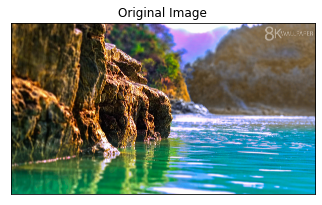

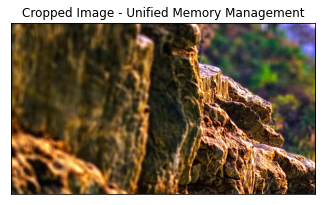

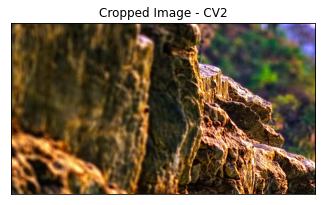

In [ ]:
## Image plotting
image_8k = cv2.imread("8K_image.jpg")
image_8k = cv2.cvtColor(image_8k, cv2.COLOR_BGR2RGB)
print("8k Image")
print()

numRows, numCols = image_8k.shape[:2] 
startRow = 0
startCol = 0
endRow = numRows//2 
endCol = numCols//2 
run(image_8k, startRow, startCol, endRow, endCol)

In [ ]:
## Runtime Comparison
if (startRow < 0 or startCol < 0 or endRow < startRow or endCol < startCol):
    print("The input dimensions for cropped image are invalid. Please try again with correct dimensions.")
else: 
  croppedWidth = endRow - startRow
  croppedHeight = endCol - startCol
  croppedImage = np.zeros([croppedWidth, croppedHeight, 3]) 

  print("Runtime for NUMBA Parallel Cropping")
  for i in [2**x for x in range(6)]:
      grid_size = ((image_8k.shape[0] + i )// i, (image_8k.shape[1] + i) // i)
      thread_no = (i, i)
      print(f"Grid Size: ({grid_size[0]}, {grid_size[1]})\nThreads Per Block: ({i}, {i})")
      %timeit crop[grid_size, thread_no](image_8k, croppedImage, startRow, startCol, croppedWidth, croppedHeight)

  print()
  print("Timing CV2 Cropping.")

  %timeit crop_img = image_8k[startRow:startRow+croppedWidth, startCol:startCol+croppedHeight]

Runtime for NUMBA Parallel Cropping
Grid Size: (4321, 7681)
Threads Per Block: (1, 1)
1 loop, best of 3: 164 ms per loop
Grid Size: (2161, 3841)
Threads Per Block: (2, 2)
10 loops, best of 3: 140 ms per loop
Grid Size: (1081, 1921)
Threads Per Block: (4, 4)
10 loops, best of 3: 137 ms per loop
Grid Size: (541, 961)
Threads Per Block: (8, 8)
10 loops, best of 3: 134 ms per loop
Grid Size: (271, 481)
Threads Per Block: (16, 16)
10 loops, best of 3: 135 ms per loop
Grid Size: (136, 241)
Threads Per Block: (32, 32)
10 loops, best of 3: 134 ms per loop

Timing CV2 Cropping.
The slowest run took 9.26 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 435 ns per loop


#Image Cropping using Explicit GPU Memory Management

##Code

In [ ]:
def run_explicit(image, startRow, startCol, endRow, endCol):
  # determining dimesion of image width(w) height(h) 
  numRows, numCols = image.shape[:2] 
  
  if (startRow < 0 or startCol < 0 or endRow > numRows or endCol > numCols):
    print("Error: The input dimensions for cropped image are out of range.")
    print("Rows Range: " + str(numRows) + " and Column Range: " + str(numCols) + ". Please try again with correct dimensions.")
    return 
  if (endRow <= startRow or endCol <= startCol):
    print("Error: Ending row and column values must be greater than starting row and column values respectively")
    return

  croppedWidth = endRow - startRow
  croppedHeight = endCol - startCol
  croppedImage = np.zeros([croppedWidth, croppedHeight, 3]) 

  #Setup grid size and thread count
  grid_size = image.shape[:2]
  thread_no = (1, 1)

  #Pass information to GPU
  dImage = cuda.to_device(image)
  dCroppedImage = cuda.to_device(croppedImage)

  #Call the kernel
  crop[grid_size, thread_no](dImage, dCroppedImage, startRow, startCol, croppedWidth, croppedHeight)

  #Transfer data back to gpu
  dCroppedImage.copy_to_host(croppedImage)

  plt.figure(figsize=(12, 12))
  plt.subplot(121), plt.imshow(image)
  plt.title("Original Image"), plt.xticks([]), plt.yticks([])

  plt.figure(figsize=(12, 12))
  plt.subplot(121), plt.imshow((croppedImage).astype(np.uint8)),plt.xticks([]), plt.yticks([])
  plt.title("Cropped Image - Explicit Memory Management")

  croppedImageCV2 = image[startRow:startRow+croppedWidth, startCol:startCol+croppedHeight]
  plt.figure(figsize=(12, 12))
  plt.subplot(121), plt.imshow((croppedImageCV2).astype(np.uint8)),plt.xticks([]), plt.yticks([])
  plt.title("Cropped Image - CV2")

  comparison = croppedImageCV2 == croppedImage
  equal_arrays = comparison.all()
  print("Manual cropped image matches cv2 cropped image: " + str(equal_arrays))
  # save image  
  img.imsave('cropped.jpg', (croppedImage).astype(npy.uint8))
  img.imsave('croppedcv2.jpg', (croppedImage).astype(npy.uint8))

##1080p Results

1080p Image

Manual cropped image matches cv2 cropped image: True


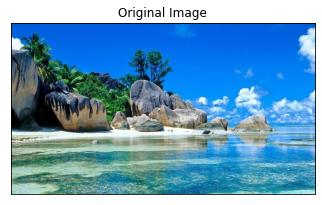

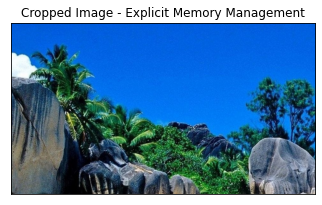

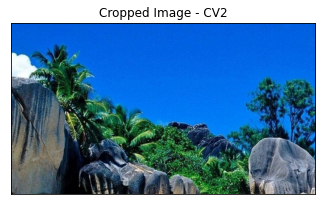

In [ ]:
## Image plotting
image = cv2.imread("1080p_image.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print("1080p Image")
print()

numRows, numCols = image.shape[:2] 
startRow =  0
startCol = 0
endRow = numRows//2
endCol = numCols//2

run_explicit(image, startRow, startCol, endRow, endCol)

In [ ]:
## Runtime Comparison
if (startRow < 0 or startCol < 0 or endRow < startRow or endCol < startCol):
    print("The input dimensions for cropped image are invalid. Please try again with correct dimensions.")
else: 
  croppedWidth = endRow - startRow
  croppedHeight = endCol - startCol
  croppedImage = np.zeros([croppedWidth, croppedHeight, 3]) 

  dImage = cuda.to_device(image)
  dCroppedImage = cuda.to_device(croppedImage)

  print("Runtime for NUMBA Parallel Cropping")
  for i in [2**x for x in range(6)]:
      grid_size = ((image.shape[0] + i )// i, (image.shape[1] + i) // i)
      thread_no = (i, i)
      print(f"Grid Size: ({grid_size[0]}, {grid_size[1]})\nThreads Per Block: ({i}, {i})")
      %timeit crop[grid_size, thread_no](dImage, dCroppedImage, startRow, startCol, croppedWidth, croppedHeight)

  print()
  print("Timing CV2 Cropping.")

  %timeit crop_img = image[startRow:startRow+croppedWidth, startCol:startCol+croppedHeight]

Runtime for NUMBA Parallel Cropping
Grid Size: (1081, 1921)
Threads Per Block: (1, 1)
1000 loops, best of 3: 2.1 ms per loop
Grid Size: (541, 961)
Threads Per Block: (2, 2)
100 loops, best of 3: 2.09 ms per loop
Grid Size: (271, 481)
Threads Per Block: (4, 4)
100 loops, best of 3: 2.09 ms per loop
Grid Size: (136, 241)
Threads Per Block: (8, 8)
The slowest run took 4.07 times longer than the fastest. This could mean that an intermediate result is being cached.
100 loops, best of 3: 515 µs per loop
Grid Size: (68, 121)
Threads Per Block: (16, 16)
1000 loops, best of 3: 170 µs per loop
Grid Size: (34, 61)
Threads Per Block: (32, 32)
The slowest run took 4.49 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 176 µs per loop

Timing CV2 Cropping.
The slowest run took 15.73 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 412 ns per loop


##4k Results

4k Image

Manual cropped image matches cv2 cropped image: True


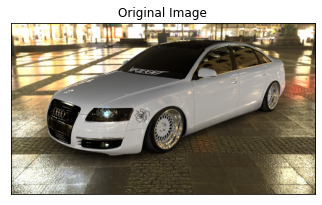

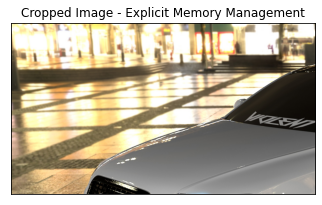

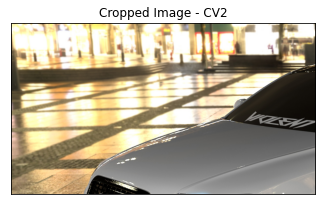

In [ ]:
## Image plotting
image_4k = cv2.imread("4k_image.jpg")
image_4k = cv2.cvtColor(image_4k, cv2.COLOR_BGR2RGB)
print("4k Image")
print()

numRows, numCols = image_4k.shape[:2] 
startRow = 0
startCol = 0
endRow = numRows//2
endCol = numCols//2 

run_explicit(image_4k, startRow, startCol, endRow, endCol)

In [ ]:
## Runtime Comparison
if (startRow < 0 or startCol < 0 or endRow < startRow or endCol < startCol):
    print("The input dimensions for cropped image are invalid. Please try again with correct dimensions.")
else: 
  croppedWidth = endRow - startRow
  croppedHeight = endCol - startCol
  croppedImage = np.zeros([croppedWidth, croppedHeight, 3]) 

  dImage = cuda.to_device(image_4k)
  dCroppedImage = cuda.to_device(croppedImage)

  print("Runtime for NUMBA Parallel Cropping")
  for i in [2**x for x in range(6)]:
      grid_size = ((image_4k.shape[0] + i )// i, (image_4k.shape[1] + i) // i)
      thread_no = (i, i)
      print(f"Grid Size: ({grid_size[0]}, {grid_size[1]})\nThreads Per Block: ({i}, {i})")
      %timeit crop[grid_size, thread_no](dImage, dCroppedImage, startRow, startCol, croppedWidth, croppedHeight)

  print()
  print("Timing CV2 Cropping.")

  %timeit crop_img = image_4k[startRow:startRow+croppedWidth, startCol:startCol+croppedHeight]

Runtime for NUMBA Parallel Cropping
Grid Size: (2161, 3841)
Threads Per Block: (1, 1)
1000 loops, best of 3: 8.42 ms per loop
Grid Size: (1081, 1921)
Threads Per Block: (2, 2)
100 loops, best of 3: 8.42 ms per loop
Grid Size: (541, 961)
Threads Per Block: (4, 4)
100 loops, best of 3: 8.42 ms per loop
Grid Size: (271, 481)
Threads Per Block: (8, 8)
100 loops, best of 3: 2.28 ms per loop
Grid Size: (136, 241)
Threads Per Block: (16, 16)
100 loops, best of 3: 955 µs per loop
Grid Size: (68, 121)
Threads Per Block: (32, 32)
1000 loops, best of 3: 812 µs per loop

Timing CV2 Cropping.
The slowest run took 14.02 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 414 ns per loop


##8k Results

8k Image

Manual cropped image matches cv2 cropped image: True


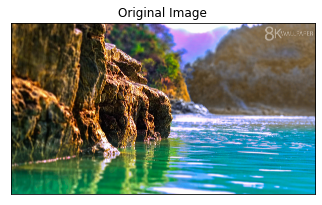

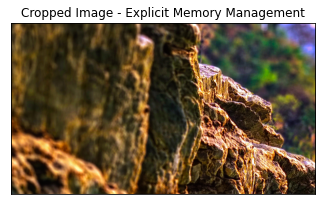

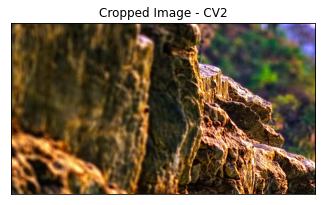

In [ ]:
## Image plotting
image_8k = cv2.imread("8K_image.jpg")
image_8k = cv2.cvtColor(image_8k, cv2.COLOR_BGR2RGB)
print("8k Image")
print()

numRows, numCols = image_8k.shape[:2] 
startRow = 0
startCol = 0
endRow = numRows//2 
endCol = numCols//2 

run_explicit(image_8k, startRow, startCol, endRow, endCol)

In [ ]:
## Runtime Comparison
if (startRow < 0 or startCol < 0 or endRow < startRow or endCol < startCol):
    print("The input dimensions for cropped image are invalid. Please try again with correct dimensions.")
else: 
  croppedWidth = endRow - startRow
  croppedHeight = endCol - startCol
  croppedImage = np.zeros([croppedWidth, croppedHeight, 3]) 

  dImage = cuda.to_device(image_8k)
  dCroppedImage = cuda.to_device(croppedImage)

  print("Runtime for NUMBA Parallel Cropping")
  for i in [2**x for x in range(6)]:
      grid_size = ((image_8k.shape[0] + i )// i, (image_8k.shape[1] + i) // i)
      thread_no = (i, i)
      print(f"Grid Size: ({grid_size[0]}, {grid_size[1]})\nThreads Per Block: ({i}, {i})")
      %timeit crop[grid_size, thread_no](dImage, dCroppedImage, startRow, startCol, croppedWidth, croppedHeight)

  print()
  print("Timing CV2 Cropping.")

  %timeit crop_img = image_8k[startRow:startRow+croppedWidth, startCol:startCol+croppedHeight]

Runtime for NUMBA Parallel Cropping
Grid Size: (4321, 7681)
Threads Per Block: (1, 1)
1000 loops, best of 3: 34.3 ms per loop
Grid Size: (2161, 3841)
Threads Per Block: (2, 2)
10 loops, best of 3: 34.4 ms per loop
Grid Size: (1081, 1921)
Threads Per Block: (4, 4)
10 loops, best of 3: 34.4 ms per loop
Grid Size: (541, 961)
Threads Per Block: (8, 8)
10 loops, best of 3: 34.4 ms per loop
Grid Size: (271, 481)
Threads Per Block: (16, 16)
10 loops, best of 3: 34.4 ms per loop
Grid Size: (136, 241)
Threads Per Block: (32, 32)
10 loops, best of 3: 34.4 ms per loop

Timing CV2 Cropping.
The slowest run took 19.42 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 409 ns per loop
